# Goal 

The goal of this blog post is to create a machine learning model that predicts an individual characteristic (in this case income) based on the basis of other demographic characteristics. We use the `folktables` package, which allows you to download and neatly organize data from the American Community Survey's Public Use Microdata Sample (PUMS). 

Once we trained a model, we will perform a fairness audit in order to assess whether or not the algorithm displays bias with respect to demographic characteristics like race or sex

# The Problem

In this blog post we will predict whether an individual's income in the state of California is over $50k based on demographic characteristics (excluding sex), and then audit for gender bias. 

We consider the following demographic characteristics along with their respective feature code: Age (AGEP), Class of worker (COW), Educational Attainment (SCHL), Marital Status (MAR), Occupation (OCCP), Relationship (RELP), Usual hours worked per week past 12 months (WKHP), Recoded detailed race code (RAC1P), Disbility code (DIS), Employment status of parents (ESP), and Citizenship Status (CIT).

Let's download the data and import some dependencies:

In [44]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "CA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000004,9,1,3701,4,6,1013097,32,30,...,34,60,60,7,8,59,33,8,58,32
1,P,2018GQ0000013,9,1,7306,4,6,1013097,45,18,...,0,0,0,91,46,46,0,89,45,0
2,P,2018GQ0000016,9,1,3755,4,6,1013097,109,69,...,105,232,226,110,114,217,2,111,2,106
3,P,2018GQ0000020,9,1,7319,4,6,1013097,34,25,...,67,0,34,34,69,0,34,35,0,0
4,P,2018GQ0000027,9,1,6511,4,6,1013097,46,31,...,47,81,10,11,79,47,44,81,47,10


We now filter the features we will use for the problem stated above: 

In [45]:
features_to_use = ['AGEP', 'COW','SCHL', 'MAR', 'OCCP', 'RELP', 'WKHP', 'RAC1P', 'DIS', 'ESP', 'CIT']
acs_data[features_to_use].head()

,AGEP,COW,SCHL,MAR,OCCP,RELP,WKHP,RAC1P,DIS,ESP,CIT
0,30,6.0,14.0,1,9610.0,16,40.0,8,2,NaN,1
1,18,NaN,14.0,5,NaN,17,NaN,1,2,NaN,1
2,69,NaN,17.0,1,NaN,17,NaN,9,1,NaN,1
3,25,NaN,1.0,5,NaN,17,NaN,1,1,NaN,1
4,31,NaN,18.0,5,NaN,16,NaN,1,2,NaN,1


We now construct a `BasicProblem`, which expresses our desire to use the features above to predict if an individual has a salary greater than $50k (PINCP) using sex (SEX) as the group label. Note that a 1 represents a Male and 2 a Female. 

In [46]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='PINCP',
    #Transform the column to check if salary > 50k 
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

We can now prepare our data for training (and testing):  

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
#Perform a train-test split 
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Basic Description of Training Data 

Before we train our model, let's explore our data using a DataFrame.

In [48]:
import pandas as pd 
df = pd.DataFrame(X_train, columns=features_to_use)
# Add a column for the group (1 for male, 2 for female)
df['SEX'] = group_train
# Add a column for the label, (True if >50k, False else)
df['SALARY>50k'] = y_train
df.head()

,AGEP,COW,SCHL,MAR,OCCP,RELP,WKHP,RAC1P,DIS,ESP,CIT,SEX,SALARY>50k
0,46.0,2.0,22.0,1.0,1821.0,0.0,45.0,9.0,2.0,0.0,1.0,2,True
1,45.0,1.0,21.0,3.0,4850.0,13.0,50.0,1.0,2.0,0.0,1.0,2,True
2,40.0,1.0,21.0,5.0,1021.0,5.0,40.0,6.0,2.0,0.0,4.0,2,True
3,59.0,1.0,24.0,1.0,300.0,0.0,40.0,6.0,2.0,0.0,4.0,1,True
4,23.0,1.0,19.0,5.0,3401.0,11.0,40.0,1.0,2.0,0.0,1.0,2,False


In [49]:
df.shape

(156532, 13)

Based on the dimension of our DataFrame, our training data has information for about 156532 individuals (and 13 features for each).

Of these individuals, 41.08% have a salary higher than $50K has showed in the following table: 

In [50]:
high_salary = df.groupby('SALARY>50k').size().reset_index(name='count')
high_salary['ratio'] = (high_salary["count"] / df.shape[0] * 100).round(2)
high_salary

,SALARY>50k,count,ratio
0,False,92232,58.92
1,True,64300,41.08


Of those individuals with a salary greater than $50K, roughly 59.83% are male while 40.17% are female. 

In [62]:
# Filter only those individuals with salary greater than $50k
filter_by_salary = df[df['SALARY>50k']==True]
high_salary_sex = filter_by_salary.groupby('SEX').size().reset_index(name='count')
high_salary_sex['ratio'] = (high_salary_sex['count'] / filter_by_salary.shape[0] * 100).round(2)
high_salary_sex

,SEX,count,ratio
0,1,38472,59.83
1,2,25828,40.17


Similarly, we find that based on the tables below, 47% of male individuals and 37% of female individuals have an income greater than $50K.

In [60]:
# Filter male
filter_by_male = df[df['SEX'] == 1]
male_high_salary = filter_by_male.groupby('SALARY>50k').size().reset_index(name='count')
male_high_salary['ratio'] = (male_high_salary['count'] / filter_by_male.shape[0] * 100).round(2)
male_high_salary

,SALARY>50k,count,ratio
0,False,44218,53.47
1,True,38472,46.53


In [61]:
# Filter female 
filter_by_female = df[df['SEX'] == 2]
female_high_salary = filter_by_female.groupby('SALARY>50k').size().reset_index(name='count')
female_high_salary['ratio'] = (female_high_salary['count'] / filter_by_female.shape[0] * 100).round(2)
female_high_salary

,SALARY>50k,count,ratio
0,False,48014,65.02
1,True,25828,34.98


It is also possible to investigate intersectionality trends in our data by studying the proportion of positive target labels broken down by `SEX` and an additional group label. In this case, let us investigate the intersectionality trends between `SEX` and  `RAC1P`. 

Recall that `RAC1P` stands for the race of the individuals (1 for White Alone, 2 for Black/African American alone, 3 for Native American alone, 4 for Alaska Native alone, 5 for Native American and Alaska Native tribes specified, 6 for Asian alone, 7 for Native Hawaiian and Other Pacific Islander alone, 8 for Some Other Race alone, 9 for two or more races).

Let's create a new DataFrame holding the desired information and then we visualize our findings using the `seaborn` package. 

[Text(0.5, 1.0, 'Individualals with salary > $50K by sex and race')]

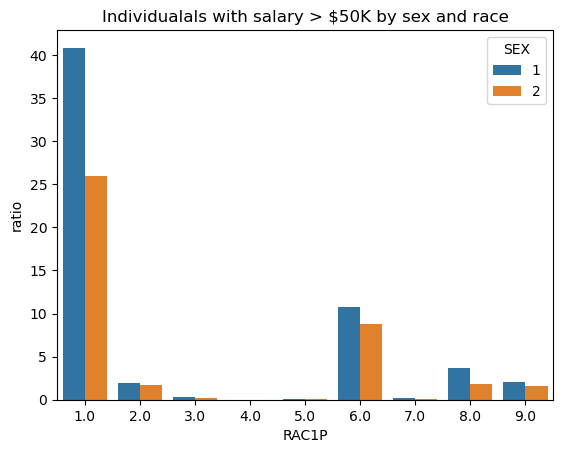

In [69]:
import seaborn as sns

# Filter those individuals with salary greater than $50k
filter_by_salary = df[df['SALARY>50k'] == True]

# Create new data frame 
intersectionality = filter_by_salary.groupby(['SEX', 'RAC1P']).size().reset_index(name='count')
intersectionality['ratio'] = (intersectionality['count'] / filter_by_salary.shape[0] * 100).round(2)

# Visualize data
sns.barplot(data=intersectionality, x = "RAC1P", y='ratio', hue='SEX').set(title= 'Individualals with salary > $50K by sex and race')


According to the data above, white male individuals make up the majority of those who earn a salary greater than $50K, followed by white woman. 

# Training the Model

Now let's train the model. We will use logistic regression with polynomial features. Let us first find which polynomial degree performs best: 

In [72]:
import warnings; warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

#Constructs a model with polynomial features 
def poly_LR(deg):
  return Pipeline([("poly", PolynomialFeatures(degree = deg)),
                   ("LR", LogisticRegression(penalty = "none", max_iter = int(1e3)))])


for deg in range(5):
  plr = poly_LR(deg = deg)
  cv_scores = cross_val_score(plr, X_train, y_train, cv=5)
  mean_score = cv_scores.mean()
  print(f"Polynomial degree = {deg}, score = {mean_score.round(3)}")

Polynomial degree = 0, score = 0.589
Polynomial degree = 1, score = 0.77
Polynomial degree = 2, score = 0.759
Polynomial degree = 3, score = 0.73
Polynomial degree = 4, score = 0.658


It seems that a degree-1 polynomial works best according to our cross-validation. So let us create and train our final model: 

In [75]:
model = poly_LR(deg = 1)
model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('LR', LogisticRegression(max_iter=1000, penalty='none'))])

# Auditing the Model

We can now test our model agains the testing data and audit its performance. For this, we make use of the confusion matrix which will allow us to calculate the Positive Predictive Value (PPV) of our model as well as the False Positive Rate (FPR) and False Negative Rate (FNR). Recall that: 

$$PPV = \frac{TP}{TP + FP} \;\;\;\;\;\;\;\;\;\; FNR = \frac{FN}{FN + TP} \;\;\;\;\;\;\;\;\; FPR = \frac{FP}{FP + TN}$$

Let's define a function to perform this calculations for us: 

In [82]:
from sklearn.metrics import confusion_matrix

def audit_model(y_test, y_pred):
    c_matrix = confusion_matrix(y_test, y_pred)
    # Get values from consution matrix:
    TN = c_matrix[0][0]
    FP = c_matrix[0][1]
    FN = c_matrix[1][0]
    TP = c_matrix[1][1]
    PPV = ( TP / (TP + FP) ).round(5)
    FNR = ( FN / (FN + TP) ).round(5)
    FPR = ( FP / (FP + TN) ).round(5)
    print(f"PPV = {PPV}, FNR = {FNR}, FPR = {FPR}") 


### Overall Measures

We are now able to examine the overall accuracy, as well as the values calculated above: 

In [83]:
# Get predictions 
y_hat = model.predict(X_test)

# Accuracy 
accuracy = (y_hat == y_test).mean().round(5)
print(f"Accuracy = {accuracy}")

# Find the other values
audit_model(y_test, y_hat)


Accuracy = 0.76848
PPV = 0.72412, FNR = 0.29729, FPR = 0.18586


We observe that the model is fairly accurate with a high PPV, which means that a predictive positive has roughly 72% of being a true positive. Moreover, our model is slightly more likely to incorrectly predict that an individual with a salary less than $50K earns more than the oppostive scenario. 

### By-Group Measures

Now, to actually evaluate if our model presents some sort of biases for any of our groups, lets analyze how the model does for each group (male and female) separately: 

In [88]:
# For male: 
accuracy_male = (y_hat == y_test)[group_test==1].mean().round(5)
print("Results for male individuals:")
print(f"Accuracy: {accuracy_male}")
audit_model(y_test[group_test==1], y_hat[group_test==1])

print("")
# For female: 
accuracy_female = (y_hat == y_test)[group_test==2].mean().round(5)
print("Results for female individuals:")
print(f"Accuracy: {accuracy_female}")
audit_model(y_test[group_test==2], y_hat[group_test==2])


Results for male individuals:
Accuracy: 0.76694
PPV = 0.7875, FNR = 0.31429, FPR = 0.16197

Results for female individuals:
Accuracy: 0.7702
PPV = 0.65014, FNR = 0.27176, FPR = 0.20757


It is evident that our model is not calibrated, given that the PPV is not the same for all the groups. According to the results above, our model is more likely to predict that a male individual earns more than $50K compared to female individuals. 

Moreover, our model also does not satisfy error rate balance. There is a clear disparity with the FNR and FPR values. The FNR value is slightly higher for male individuals, which means that male individuals are slightly more likely to be predicted a negative label when their label is actually positive. The FPR value is greater for female individuals, meaning that a female individual is more likely to be incorrectly predicted a positive label when it is actually negative. 

Finally, our model does not satisfy statistical parity given that the PPV values for both groups are different. 

# Conclusion 

There are different individuals/companies that could benefit from a model that is able to predict an individual's income. For instance, this model could be used by companies to strategically advertise their products to individuals based on their income. A more serious example is could be an insurer or a loaner that make decisions according to an individual's income. 

According to the audit of our model above, our model seems to display some problematic biases. First, our model seems to not be calibrated. This is problematic given that our model seems to be more accurate in terms of positive labels for a group (in this case male individuals). Moreover, our model does not satisfy error rate balance, meaning that it makes different type of mistakes for different groups. 

Due to this results, our model could negatively affect some individuals. For example, if there is a government program designated to help individuals making less than $50K a year, female individuals would be more likely to incorrectly be predicted a higher salary thus not receiving aid from the government. In the example above, for insurers or loaners, male individuals would be negatively impacted as the model is slightly more likely to predict that male individuals earn less than they actually do. Overall, this model could definitely have negative impact on different groups, which represents a form of allocative bias. 

Beyond these biases, it does not really feel right to deploy a model to make important decisions such as receiving aid from the government or an important credit. It is hard for a model to take a hollistic particular approach for each individual. A calibrated model might be useful to get some initial information about an individual, but there should be poeple in charge of regulating the biases for a specific individual. 